## OCCF

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [4]:
# Import data

# Training Data
df_train=pd.read_csv('./ua.base',sep='\t',header=None,engine='python')

# Test Data
df_test=pd.read_csv('./ua.test',sep='\t',header=None,engine='python')

In [5]:
num_user=943
num_item=1682

In [6]:
# user-item matrix
def rating_matrix(df):
    R=np.zeros((num_user,num_item))
    df.columns=['user_id','item_id','rating','timestamp']
    for index in range(len(df)):
        u=df['user_id'][index]-1
        i=df['item_id'][index]-1
        R[u,i]=df['rating'][index]
    return R

In [7]:
# preference matrix
def preference_matrix(R):
    P=np.zeros((num_user,num_item))
    for i in range(num_user):
        for j in range(num_item):
            if R[i,j]>0:
                P[i,j]=1
    return P

In [8]:
# confidence matrix
def confidence_matrix(R):
    C=np.zeros((num_user,num_item))
    for i in range(num_user):
        for j in range(num_item):
            C[i,j]=1+40*R[i,j]
    return C

In [9]:
# Transform dataframe to matrix
R_train=rating_matrix(df_train) # Training Data
P_train=preference_matrix(R_train) # Training Data
C_train=confidence_matrix(R_train) # Training Data

R_test=rating_matrix(df_test) # Test Data
P_test=preference_matrix(R_test) # Test Data

In [35]:
def percent(i,j,A):
    index=[k for k in range(num_item) if R_train[i,k]==0]
    lst=[]
    for k in index:
        lst.append(A[i,k])
    lst_sort=sorted(lst)
    return 1-(lst_sort.index(A[i,j])/len(lst_sort))

In [36]:
# evaluation method: rank
def rank(T,R):
    sum_rating=0
    rank=0
    for i in range(num_user):
        for j in range(num_item):
            if T[i,j]!=0:
                sum_rating+=T[i,j]
                rank+=T[i,j]*percent(i,j,R)
    return rank/sum_rating

In [37]:
# initial values
rank_occf=[]
K=30
X=np.random.normal(scale=1.0/K,size=(num_user,K))
Y=np.random.normal(scale=1.0/K,size=(num_item,K))

In [38]:
for epoch in range(100):
    for u in range(num_user):
        C=np.zeros((num_item,num_item))
        for i in range(num_item):
            C[i,i]=C_train[u,i]
        X[u,:]=np.linalg.solve(Y.T@C@Y+0.002*np.eye(K),Y.T@C@P_train[u,:].T)
    for i in range(num_item):
        C=np.zeros((num_user,num_user))
        for u in range(num_user):
            C[u,u]=C_train[u,i]
        Y[i,:]=np.linalg.solve(X.T@C@X+0.002*np.eye(K),X.T@C@P_train[:,i])
    rank_occf.append(rank(R_test,X@Y.T))

In [39]:
print('rank of OCCF: ',rank(R_test,X@Y.T))

rank of OCCF:  0.08710765934065061


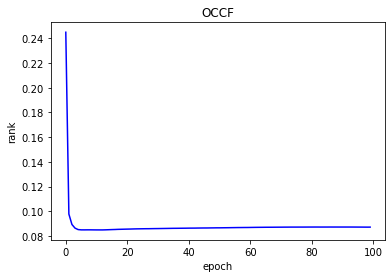

In [40]:
# plot
epoch=[i for i in range(100)]
plt.plot(epoch,rank_occf,'b') # rank plot for OCCF
plt.xlabel('epoch')
plt.ylabel('rank')
plt.title('OCCF')
plt.show()